# Connect To Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/MyDrive/CMP/"

Mounted at /content/drive


# Local

In [1]:
root = './'

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data Preparation

In [3]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel(root+'Datasets/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [4]:
SUBTLEX_df['zipf'].describe()

count    74286.000000
mean         2.479172
std          0.835829
min          1.592864
25%          1.768955
50%          2.291834
75%          2.954592
max          7.621174
Name: zipf, dtype: float64

In [5]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] > 3:
        category = 'HF'
    else:
        category = 'LF'
    return category

In [6]:
with open(root+'Datasets/FastText_V3/words_2M.pkl', 'rb') as f:
  words = pickle.load(f)

with open(root+'Datasets/FastText_V3/nonwords_2M.pkl', 'rb') as f:
  nonwords = pickle.load(f)

In [7]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

In [8]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
word_df = pd.concat([elp_words, elp_nonwords])

# 
word_df.fillna(0, inplace=True)
word_df['category'] = word_df.apply(lambda row: categorise_by_zipf(row), axis=1)
word_df.drop_duplicates(subset=['string'], inplace=True)

In [9]:
word_df = word_df.sample(frac=1.0)
word_df.head()

,string,freq,represention,code,label,zipf,category
10020,gisdain,0,"[-0.008016349, 0.009628572, 0.061261207, -0.00...","[0, 1]",0,0.000000,NW
16053,harnful,0,"[-0.018260118, -0.032788992, 0.11135751, 0.010...","[0, 1]",0,0.000000,NW
39009,larts,0,"[-0.01137622, 0.0030369982, 0.06992559, 0.0480...","[0, 1]",0,0.000000,NW
11249,Agypt,0,"[-0.0005754954, -0.053105045, 0.06405293, 0.04...","[0, 1]",0,0.000000,NW
22962,mosquitoes,1560,"[0.027048161, -0.013255942, 0.041322533, 0.015...","[1, 0]",1,3.260317,HF


In [10]:
word_df.drop_duplicates(subset=['string'], inplace=True)

In [11]:
word_df.groupby('category').count()

,string,freq,represention,code,label,zipf
category,,,,,,
HF,14333,14333,14333,14333,14333,14333
LF,19645,19645,19645,19645,19645,19645
NW,40339,40339,40339,40339,40339,40339


In [12]:
X_train, X_test, y_train, y_test = train_test_split(np.array(list(word_df['represention'])), word_df['label'].to_numpy(), test_size=0.2, shuffle=True)

# Logistic Regression

## GridSearch

In [13]:
param_grid = [
  {'solver': ['liblinear'],  'C': np.logspace(-3,3,7), "penalty":["l1","l2"]},
  {'solver': ['newton-cg'],  'C': np.logspace(-3,3,7), "penalty":["l2"]},
  {'solver': ['lbfgs'],  'C': np.logspace(-3,3,7), "penalty":["l2"]},
  {'solver': ['sag'],  'C': np.logspace(-3,3,7), "penalty":["l2"]},
  {'solver': ['saga'],  'C': np.logspace(-3,3,7), "penalty":["elasticnet", "l1", "l2"]},
]
logreg = LogisticRegression(max_iter=1000)
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1, verbose=10)
logreg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


C:\Users\Lenovo\anaconda3\envs\cmdstan\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\cmdstan\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\cmdstan\lib\site-packages\sklearn\linear_model\_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\Users\Leno

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l2'], 'solver': ['newton-cg']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l2'], 'solver': ['sag']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['elasticnet', 'l1', 'l2'],
                          'solver': ['saga']}],
             verbose=10)

In [14]:
print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("best accuracy :", logreg_cv.best_score_)
print("mean accuracies :", logreg_cv.cv_results_['mean_test_score'])

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
best accuracy : 0.9908331190822949
mean accuracies : [0.54165475 0.85459103 0.95616708 0.97318894 0.98085886 0.98284363
 0.98970617 0.98856241 0.99063129 0.99083312 0.99047991 0.99069857
 0.99049673 0.99054719 0.85511244 0.9731553  0.98282681 0.98856241
 0.99083312 0.99068176 0.99053037 0.85517972 0.9731553  0.98282681
 0.98856241 0.99083312 0.99068176 0.99053037 0.85985562 0.97318894
 0.98282681 0.98856241 0.99079948 0.99053037 0.99049673        nan
 0.54165475 0.85512925        nan 0.95652031 0.9731553         nan
 0.98090932 0.98282681        nan 0.98985755 0.98859605        nan
 0.99079949 0.99076584        nan 0.99061447 0.99064812        nan
 0.99056401 0.99061447]


tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}

## Logistic regression fit by best params

In [16]:
# LR_classifier = LogisticRegression(solver= 'liblinear',
#                                    C=10,
#                                    penalty='l2',
#                                    max_iter=1000,
#                                    n_jobs=-1,
#                                    verbose=1)
# LR_classifier.fit(X_train, y_train)

C:\Users\Lenovo\anaconda3\envs\cmdstan\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]

LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='liblinear',
                   verbose=1)

In [15]:
LR_classifier = LogisticRegression(solver= logreg_cv.best_params_['solver'],
                                   C=logreg_cv.best_params_['C'],
                                   penalty=logreg_cv.best_params_['penalty'],
                                   max_iter=1000,
                                   n_jobs=-1,
                                   verbose=1)
LR_classifier.fit(X_train, y_train)

[LibLinear]

C:\Users\Lenovo\anaconda3\envs\cmdstan\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


LogisticRegression(C=10.0, max_iter=1000, n_jobs=-1, solver='liblinear',
                   verbose=1)

In [18]:
acc_score = LR_classifier.score(X_test, y_test)
print(acc_score)

0.9901776103336921


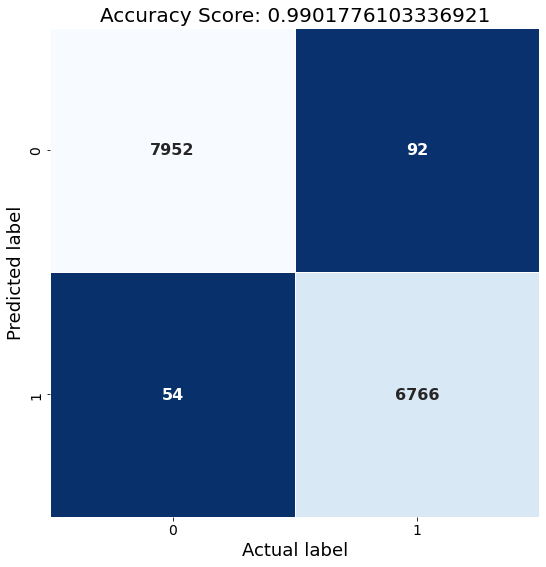

In [19]:
test_predictions = LR_classifier.predict(X_test)
cm = metrics.confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig('./Clf_Plots/LR_test_ACC')

# Get Probabilities on full dataset


In [20]:
full_predictions = LR_classifier.predict(np.array(list(word_df['represention'])))
acc_score = LR_classifier.score(np.array(list(word_df['represention'])), word_df['label'].to_numpy())
print(acc_score)

0.9917650066606564


In [21]:
print(metrics.classification_report(word_df['label'].to_numpy(), full_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9947    0.9901    0.9924     40339
           1     0.9883    0.9938    0.9910     33978

    accuracy                         0.9918     74317
   macro avg     0.9915    0.9919    0.9917     74317
weighted avg     0.9918    0.9918    0.9918     74317



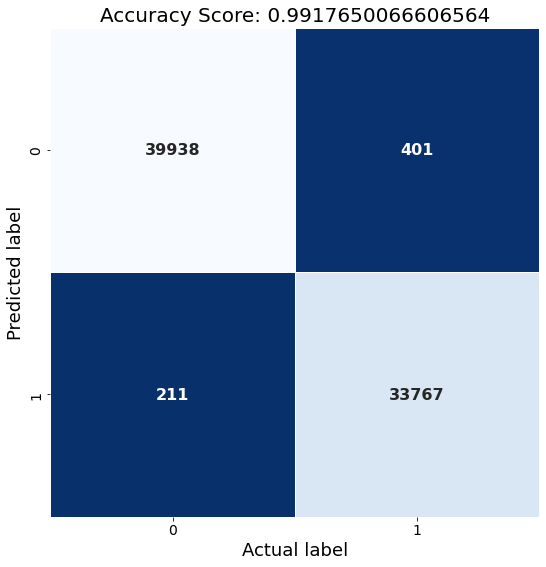

In [22]:
cm = metrics.confusion_matrix(word_df['label'].to_numpy(), full_predictions)
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig('./Clf_Plots/LR_full_ACC')

In [23]:
full_dataset_predictions = LR_classifier.predict_proba(np.array(list(word_df['represention'])))

In [24]:
word_df['word_prob'] = full_dataset_predictions[:,1]
word_df['nword_prob'] = full_dataset_predictions[:,0]

In [25]:
word_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                          nword_prob  \
              mean       std  count       max           min       mean   
category                                                                 
HF        0.986035  0.059564  14333  1.000000  2.598540e-05   0.013965   
LF        0.975616  0.080746  19645  1.000000  8.576777e-05   0.024384   
NW        0.016587  0.087053  40339  0.999994  5.789514e-13   0.983413   

                                                   
               std  count       max           min  
category                                           
HF        0.059564  14333  0.999974  0.000000e+00  
LF        0.080746  19645  0.999914  2.590256e-08  
NW        0.087053  40339  1.000000  6.194477e-06

In [26]:
word_df_to_save = word_df.drop(['represention', 'code'], axis=1)

In [27]:
word_df_to_save.to_csv(root+"Datasets/fastText_LR.csv", header=0, index=False)